In [2]:
!pip install python-docx trafilatura markdown-it-py mdit_plain pypdf python-pptx openpyxl nltk

In [10]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack_experimental.super_components.converters import MultiFileConverter
from haystack_experimental.super_components.indexers import DocumentIndexer
from haystack_experimental.super_components.preprocessors import DocumentPreProcessor

# SuperComponents

Supercomponents in general behave like any other component. They have init params, optional from_dict() and to_dict() methods as usual. The init params typically determine how the internal pipeline is constructed (e.g. which components are used).

Supercomponents can make it easier to build common pipeline patterns.

Here, we are building an indexing pipeline for a RAG system.


In [11]:
file_converter = MultiFileConverter()
preprocessor = DocumentPreProcessor()
document_store = InMemoryDocumentStore()
indexer = DocumentIndexer(document_store=document_store)

pipe = Pipeline()

pipe.add_component("converter", file_converter)
pipe.add_component("preprocessor", preprocessor)
pipe.add_component("indexer", indexer)

pipe.connect("converter.documents", "preprocessor.documents")
pipe.connect("preprocessor.documents", "indexer.documents")

🚅 Components
  - converter: MultiFileConverter
  - preprocessor: DocumentPreProcessor
  - indexer: DocumentIndexer
🛤️ Connections
  - converter.documents -> preprocessor.documents (List[Document])
  - preprocessor.documents -> indexer.documents (List[Document])

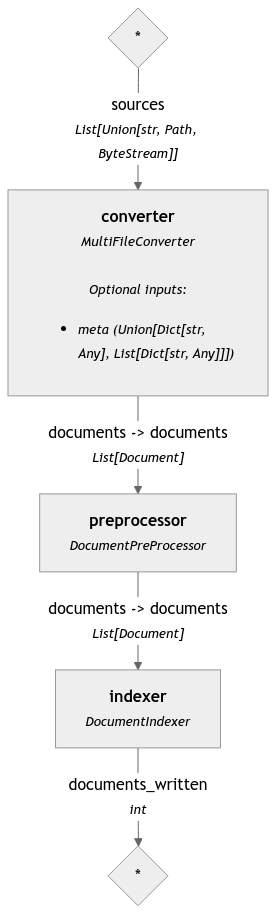

In [12]:
pipe.show()

Our pipeline handles CSV, DOCX, HTML, JSON, Markdown, TXT, PDF, PPTX, and XLSX.

Let's test it out!

In [13]:
example_files = [
    "sample_files/sample_docx.docx",
    "sample_files/sample_pptx.pptx",
    "sample_files/sample.md",
    "sample_files/sample_pdf_1.pdf",
]

result = pipe.run({"sources": example_files})

print(f"Wrote {result['indexer']['documents_written']} documents to the document store.")

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

Wrote 6 documents to the document store.


Let's view the documents!

You can see that they are split, and embedded.

In [14]:
document_store.filter_documents()

[Document(id=575e058e31109793279bb32e9eca01b0ecef8a4a687a8eb235d77b11f1746956, content: 'Sample Docx File The US has "passed the peak" on new coronavirus cases, President Donald Trump said ...', meta: {'file_path': 'sample_docx.docx', 'docx': DOCXMetadata(author='Saha, Anirban', category='', comments='', content_status='', created='2020-07-14T08:14:00+00:00', identifier='', keywords='', language='', last_modified_by='Saha, Anirban', last_printed=None, modified='2020-07-14T08:16:00+00:00', revision=1, subject='', title='', version=''), 'source_id': '86ba10e1b023f2dfdd576079468a060522f31be54cf6e41515d2311522002b06', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, embedding: vector of size 768),
 Document(id=afce88a93fde936bd049139ff5802dcbe4e1af65b9040e88523ee868b50aec16, content: 'type: intro
 date: 1.1.2023 pip install farm-haystack What to build with Haystack Ask questions in na...', meta: {'file_path': 'sample.md', 'source_id': '9a881cceb8042a3db81c9390bf8c7ba28979030823bf038

## Expanding SuperComponents
What makes SuperComponents special is the ability to expand it by calling their `to_super_component_dict()` method. This converts the component to a generic `SuperComponent` that contains the pipeline constructed by the SuperComponent. From there on the pipeline can be changed in any way.

Let's use this feature to check how this pipeline would look like without using super components.

In [28]:
file_converter_serialized = file_converter._to_super_component_dict()
Pipeline.from_dict(file_converter_serialized["init_parameters"]["pipeline"])


🚅 Components
  - router: FileTypeRouter
  - docx: DOCXToDocument
  - html: HTMLToDocument
  - json: JSONConverter
  - md: MarkdownToDocument
  - txt: TextFileToDocument
  - pdf: PyPDFToDocument
  - pptx: PPTXToDocument
  - xlsx: XLSXToDocument
  - joiner: DocumentJoiner
  - csv: CSVToDocument
🛤️ Connections
  - router.text/csv -> csv.sources (List[Union[str, Path, ByteStream]])
  - router.application/vnd.openxmlformats-officedocument.wordprocessingml.document -> docx.sources (List[Union[str, Path, ByteStream]])
  - router.text/html -> html.sources (List[Union[str, Path, ByteStream]])
  - router.application/json -> json.sources (List[Union[str, Path, ByteStream]])
  - router.text/markdown -> md.sources (List[Union[str, Path, ByteStream]])
  - router.text/plain -> txt.sources (List[Union[str, Path, ByteStream]])
  - router.application/pdf -> pdf.sources (List[Union[str, Path, ByteStream]])
  - router.application/vnd.openxmlformats-officedocument.presentationml.presentation -> pptx.source

That's a lot of components just for file conversion.


The full pipeline, that has the same functionality would look like this. &#x1F635;	

In [35]:
from haystack import Pipeline
from haystack.components.converters.csv import CSVToDocument
from haystack.components.converters.docx import DOCXToDocument
from haystack.components.converters.html import HTMLToDocument
from haystack.components.converters.pptx import PPTXToDocument
from haystack.components.converters.pypdf import PyPDFToDocument
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.converters.xlsx import XLSXToDocument
from haystack.components.embedders.sentence_transformers_document_embedder import SentenceTransformersDocumentEmbedder
from haystack.components.joiners.document_joiner import DocumentJoiner
from haystack.components.preprocessors.document_cleaner import DocumentCleaner
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.routers.file_type_router import FileTypeRouter
from haystack.components.writers.document_writer import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

file_classifier = FileTypeRouter(
    mime_types=[
        "text/plain",
        "application/pdf",
        "text/markdown",
        "text/html",
        "application/vnd.openxmlformats-officedocument.wordprocessingml.document",
        "application/vnd.openxmlformats-officedocument.presentationml.presentation",
        "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",
        "text/csv"
    ])
text_converter = TextFileToDocument(encoding="utf-8")
pdf_converter = PyPDFToDocument()
markdown_converter = TextFileToDocument(encoding="utf-8")
html_converter = HTMLToDocument()
docx_converter = DOCXToDocument()
pptx_converter = PPTXToDocument()
xlsx_converter = XLSXToDocument()
csv_converter = CSVToDocument(encoding="utf-8")
joiner = DocumentJoiner(join_mode="concatenate", sort_by_score=False)
joiner_xlsx = DocumentJoiner(join_mode="concatenate", sort_by_score=False)
splitter = DocumentSplitter(split_by="word", split_length=250)
cleaner = DocumentCleaner()
document_embedder = SentenceTransformersDocumentEmbedder()
document_store = InMemoryDocumentStore()
writer = DocumentWriter(document_store=document_store)

pipeline = Pipeline()
pipeline.add_component("file_classifier", file_classifier)
pipeline.add_component("text_converter", text_converter)
pipeline.add_component("pdf_converter", pdf_converter)
pipeline.add_component("markdown_converter", markdown_converter)
pipeline.add_component("html_converter", html_converter)
pipeline.add_component("docx_converter", docx_converter)
pipeline.add_component("pptx_converter", pptx_converter)
pipeline.add_component("xlsx_converter", xlsx_converter)
pipeline.add_component("csv_converter", csv_converter)
pipeline.add_component("joiner", joiner)
pipeline.add_component("joiner_xlsx", joiner_xlsx)
pipeline.add_component("splitter", splitter)
pipeline.add_component("cleaner", cleaner)
pipeline.add_component("document_embedder", document_embedder)
pipeline.add_component("writer", writer)
pipeline.connect("file_classifier.text/plain", "text_converter.sources")
pipeline.connect("file_classifier.application/pdf", "pdf_converter.sources")
pipeline.connect("file_classifier.text/markdown", "markdown_converter.sources")
pipeline.connect("file_classifier.text/html", "html_converter.sources")
pipeline.connect("file_classifier.application/vnd.openxmlformats-officedocument.wordprocessingml.document", "docx_converter.sources")
pipeline.connect("file_classifier.application/vnd.openxmlformats-officedocument.presentationml.presentation", "pptx_converter.sources")
pipeline.connect("file_classifier.application/vnd.openxmlformats-officedocument.spreadsheetml.sheet", "xlsx_converter.sources")
pipeline.connect("file_classifier.text/csv", "csv_converter.sources")
pipeline.connect("text_converter.documents", "joiner.documents")
pipeline.connect("pdf_converter.documents", "joiner.documents")
pipeline.connect("markdown_converter.documents", "joiner.documents")
pipeline.connect("html_converter.documents", "joiner.documents")
pipeline.connect("docx_converter.documents", "joiner.documents")
pipeline.connect("pptx_converter.documents", "joiner.documents")
pipeline.connect("joiner.documents", "cleaner.documents")
pipeline.connect("cleaner.documents", "splitter.documents")
pipeline.connect("xlsx_converter.documents", "joiner.documents")
pipeline.connect("csv_converter.documents", "joiner.documents")
pipeline.connect("document_embedder.documents", "writer.documents")


🚅 Components
  - file_classifier: FileTypeRouter
  - text_converter: TextFileToDocument
  - pdf_converter: PyPDFToDocument
  - markdown_converter: TextFileToDocument
  - html_converter: HTMLToDocument
  - docx_converter: DOCXToDocument
  - pptx_converter: PPTXToDocument
  - xlsx_converter: XLSXToDocument
  - csv_converter: CSVToDocument
  - joiner: DocumentJoiner
  - joiner_xlsx: DocumentJoiner
  - splitter: DocumentSplitter
  - cleaner: DocumentCleaner
  - document_embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - file_classifier.text/plain -> text_converter.sources (List[Union[str, Path, ByteStream]])
  - file_classifier.application/pdf -> pdf_converter.sources (List[Union[str, Path, ByteStream]])
  - file_classifier.text/markdown -> markdown_converter.sources (List[Union[str, Path, ByteStream]])
  - file_classifier.text/html -> html_converter.sources (List[Union[str, Path, ByteStream]])
  - file_classifier.application/vnd.openxmlformats-off